1. Динамика новых случаев для разных стран (за всё время и за конкретный период на выбор пользователя)

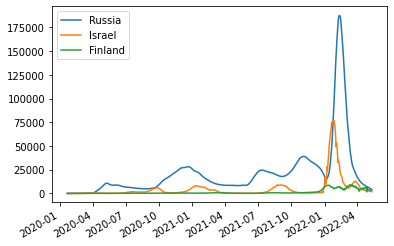

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
from matplotlib.dates import DateFormatter

dayZ = '1/22/20'
toDate = lambda time: datetime.strptime(time, '%m/%d/%y')
toHuman = lambda time: datetime.strptime(time, '%m/%d/%y').strftime('%Y-%m-%d')
prevDay = lambda time: (datetime.strptime(time, '%m/%d/%y') - dt.timedelta(days=1)).strftime('%m/%d/%y').lstrip('0').replace(' 0', ' ')

data = pd.read_csv('time_series_covid19_confirmed_global.csv', sep=',')

countries = ['Russia', 'Israel', 'Finland']
time_period = ['1/22/20', '5/12/22']
if input('Do you want to see the all period? Type yes if you do:') not in ['yes', 'Yes', 'Y', 'y']:
    time_period[0] = input('Enter start day:')
    time_period[1] = input('Enter end day:')

data = data.loc[data['Country/Region'].isin(countries)].groupby(['Country/Region']).sum()

start_point = 0
if (toDate(time_period[0]) > toDate(dayZ)):
    start_point = data.iloc[:, data.columns.get_loc(prevDay(time_period[0]))]
data = data.iloc[:, data.columns.get_loc(time_period[0]):data.columns.get_loc(time_period[1])]

for i in range(data.columns.size-1, -1, -1):
    data.iloc[:,i] -= (start_point if i == 0 else data.iloc[:,i-1])

dates = np.arange(toHuman(time_period[0]), toHuman(time_period[1]), dtype='datetime64')

fig, ax = plt.subplots()
for country in countries:
    ax.plot(dates, data.loc[country], label=country)

ax.legend(countries) 
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
fig.autofmt_xdate()
plt.show()

2. Длина каждой волны для разных стран (длительность подъемов и спусков)

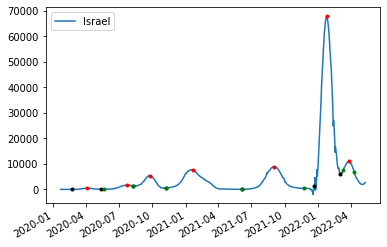

,Country,Wave,StartDate,EndDate
0,Israel,1,2020-02-21,2020-05-21
1,Israel,2,2020-05-11,2020-08-09
2,Israel,3,2020-08-09,2020-11-07
3,Israel,4,2020-11-07,2021-06-05
4,Israel,5,2021-06-05,2021-11-22
5,Israel,6,2021-12-22,2022-03-12
6,Israel,7,2022-03-02,2022-04-11


In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
from matplotlib.dates import DateFormatter
import scipy.signal

data = pd.read_csv('time_series_covid19_confirmed_global.csv', sep=',')

countries = ['Israel']
time_period = ['1/22/20', '5/12/22']

data = data.loc[data['Country/Region'].isin(countries)].groupby(['Country/Region']).sum()

for i in range(data.columns.size-1, 0, -1):
    data.iloc[:,i] -= data.iloc[:,i-1]

for country in countries: 
    data.loc[country] = scipy.signal.savgol_filter(data.loc[country], 50, 3)

data = data.iloc[:, data.columns.get_loc(time_period[0]):data.columns.get_loc(time_period[1])]

dates = np.arange(toHuman(time_period[0]), toHuman(time_period[1]), dtype='datetime64')

fig, ax = plt.subplots()
for country in countries:
    ax.plot(dates, data.loc[country], label=country) 

wave_c = [0] * len(countries)
starts = [[]] * len(countries)
ends = [[]] * len(countries)

for idx, country in enumerate(countries):
    for i in range(30, data.columns.size-30):
        if i % 10 == 0:
            if data.loc[country][i+15]/data.loc[country][i] > 1.1:
                if len(starts[idx]) <= wave_c[idx]:
                    starts[idx].append([dates[i], data.loc[country][i]])
            if data.loc[country][i-15]/data.loc[country][i] > 1.1:
                if wave_c[idx] != 0:
                    if len(ends[idx]) < wave_c[idx]:
                        ends[idx].append([dates[i], data.loc[country][i]])
                    else:
                        ends[idx].pop()
                        ends[idx].append([dates[i], data.loc[country][i]])
        if max(data.loc[country][i-30:i]) < data.loc[country][i] > max(data.loc[country][i+1:i+30]):
            ax.plot(dates[i], data.loc[country][i], '.r')
            wave_c[idx] += 1

for idx, country in enumerate(countries):
    for i in range(len(ends[idx]), wave_c[idx]):
        ends[idx].append(starts[idx][len(ends[idx])-1])

for idx, country in enumerate(countries):
    for start in starts[idx]:
        ax.plot(start[0], start[1], '.k')
    for end in ends[idx]:
        ax.plot(end[0], end[1], '.g')

ax.legend(countries) 
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
fig.autofmt_xdate()
plt.show()

strIdx = 0
waves = pd.DataFrame(columns=['Country', 'Wave', 'StartDate', 'EndDate'])
for idx, country in enumerate(countries):
    for i in range(wave_c[idx]):
        waves.loc[strIdx] = {'Country': country, 'Wave': i+1, 'StartDate': starts[idx][i][0], 'EndDate': ends[idx][i][0]}
        strIdx += 1
waves
